In [1]:
import torch_cka
from torch_cka import CKA
import timm
import torch
from torchvision import datasets, transforms
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Seed
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(42)
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
# Pull down weights from SLIP repo (https://github.com/facebookresearch/SLIP)
!wget -nc https://dl.fbaipublicfiles.com/slip/clip_base_25ep.pt
!wget -nc https://dl.fbaipublicfiles.com/slip/slip_base_25ep.pt
!wget -nc https://dl.fbaipublicfiles.com/slip/slip_base_100ep.pt

File ‘clip_base_25ep.pt’ already there; not retrieving.

File ‘slip_base_25ep.pt’ already there; not retrieving.

File ‘slip_base_100ep.pt’ already there; not retrieving.



In [4]:
# Get state_dict and load model
def load_model(model_arch, weight_path,
        visual_keyword = 'module.visual.',
        linear_keyword = 'head'):

    checkpoint = torch.load(weight_path)
    # rename CLIP pre-trained keys
    state_dict = checkpoint['state_dict']
    for k in list(state_dict.keys()):
        # retain only base_encoder up to before the embedding layer
        if k.startswith(visual_keyword) and not k.startswith(visual_keyword + linear_keyword):
            # remove prefix
            state_dict[k[len(visual_keyword):]] = state_dict[k]
        # delete renamed or unused k
        del state_dict[k]
        
    # Get model and load checkpoints
    model = timm.models.create_model(model_arch, num_classes=1000)
    msg = model.load_state_dict(state_dict, strict=False)
    assert set(msg.missing_keys) == {"%s.weight" % linear_keyword, "%s.bias" % linear_keyword}
    return model

In [5]:
slip = load_model('vit_base_patch16_224','slip_base_25ep.pt')
clip = load_model('vit_base_patch16_224','clip_base_25ep.pt')

In [6]:
# Get dataset
cifar100_full = datasets.CIFAR100('/data/cifar100/', train=True, download=True,
        transform=transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ]))

cifar100_subset = torch.utils.data.Subset(cifar100_full, 
                    random.sample(range(len(cifar100_full)), 500))

dataloader = torch.utils.data.DataLoader(cifar100_subset, batch_size=32,
            num_workers=8, shuffle=False,
            worker_init_fn=seed_worker,
            generator=g)

Files already downloaded and verified


In [7]:
cka = CKA(slip, clip,
          model1_name="SLIP ViT Base (25epoch)",   # good idea to provide names to avoid confusion
          model2_name="CLIP ViT Base (25epoch)",   
          #model1_layers=layer_names_resnet18, # List of layers to extract features from
          #model2_layers=layer_names_resnet34, # extracts all layer features by default
          device='cuda')

cka.compare(dataloader) # secondary dataloader is optional

results = cka.export()  # returns a dict that contains model names, layer names
                        # and the CKA matrix

/home/local/KHQ/benjamin.pikus/miniconda3/envs/learn/lib/python3.7/site-packages/torch_cka/cka.py:62: UserWarning: Model 1 seems to have a lot of layers. Consider giving a list of layers whose features you are concerned with through the 'model1_layers' parameter. Your CPU/GPU will thank you :)
  warn("Model 1 seems to have a lot of layers. " \
/home/local/KHQ/benjamin.pikus/miniconda3/envs/learn/lib/python3.7/site-packages/torch_cka/cka.py:69: UserWarning: Model 2 seems to have a lot of layers. Consider giving a list of layers whose features you are concerned with through the 'model2_layers' parameter. Your CPU/GPU will thank you :)
  warn("Model 2 seems to have a lot of layers. " \
/home/local/KHQ/benjamin.pikus/miniconda3/envs/learn/lib/python3.7/site-packages/torch_cka/cka.py:145: UserWarning: Dataloader for Model 2 is not given. Using the same dataloader for both models.
  warn("Dataloader for Model 2 is not given. Using the same dataloader for both models.")
| Comparing features |

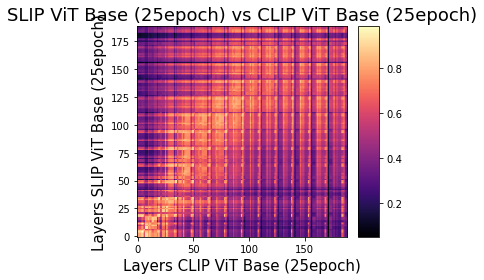

In [8]:
cka.plot_results()

/home/local/KHQ/benjamin.pikus/miniconda3/envs/learn/lib/python3.7/site-packages/torch_cka/cka.py:51: UserWarning: Both model have identical names - SLIP ViT Base (25epoch). It may cause confusion when interpreting the results. Consider giving unique names to the models :)
  warn(f"Both model have identical names - {self.model2_info['Name']}. " \
| Comparing features |: 100%|██████████| 16/16 [05:28<00:00, 20.52s/it]


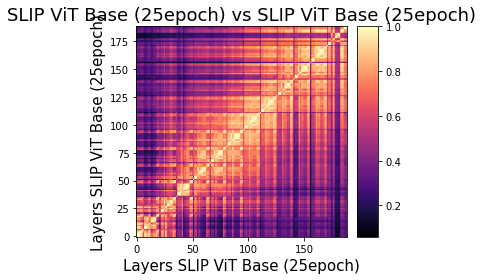

In [9]:
cka_same = CKA(slip, slip,
          model1_name="SLIP ViT Base (25epoch)",   # good idea to provide names to avoid confusion
          model2_name="SLIP ViT Base (25epoch)",   
          #model1_layers=layer_names_resnet18, # List of layers to extract features from
          #model2_layers=layer_names_resnet34, # extracts all layer features by default
          device='cuda')

cka_same.compare(dataloader) # secondary dataloader is optional

results_same = cka_same.export()  # returns a dict that contains model names, layer names
                        # and the CKA matrix
cka_same.plot_results()

| Comparing features |: 100%|██████████| 16/16 [05:28<00:00, 20.56s/it]


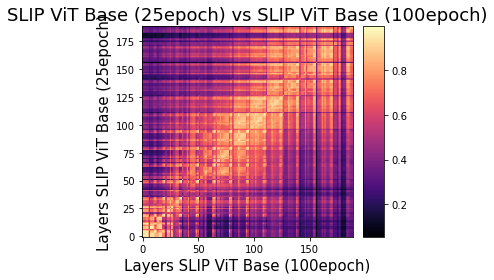

In [10]:
slip_100 = load_model('vit_base_patch16_224','slip_base_100ep.pt')
cka_slipepochs = CKA(slip, slip_100,
          model1_name="SLIP ViT Base (25epoch)",   # good idea to provide names to avoid confusion
          model2_name="SLIP ViT Base (100epoch)",   
          #model1_layers=layer_names_resnet18, # List of layers to extract features from
          #model2_layers=layer_names_resnet34, # extracts all layer features by default
          device='cuda')

cka_slipepochs.compare(dataloader) # secondary dataloader is optional

results_slipepochs = cka_slipepochs.export()  # returns a dict that contains model names, layer names
                        # and the CKA matrix
cka_slipepochs.plot_results()

/home/local/KHQ/benjamin.pikus/miniconda3/envs/learn/lib/python3.7/site-packages/torch_cka/cka.py:51: UserWarning: Both model have identical names - CLIP ViT Base (25epoch). It may cause confusion when interpreting the results. Consider giving unique names to the models :)
  warn(f"Both model have identical names - {self.model2_info['Name']}. " \
| Comparing features |: 100%|██████████| 16/16 [05:30<00:00, 20.64s/it]


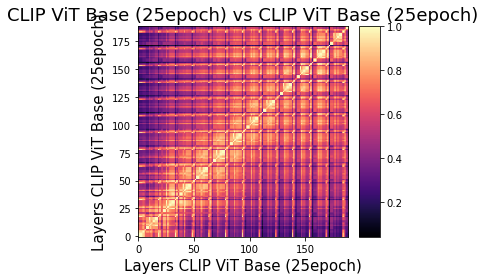

In [11]:
cka_clip = CKA(clip, clip,
          model1_name="CLIP ViT Base (25epoch)",   # good idea to provide names to avoid confusion
          model2_name="CLIP ViT Base (25epoch)",   
          #model1_layers=layer_names_resnet18, # List of layers to extract features from
          #model2_layers=layer_names_resnet34, # extracts all layer features by default
          device='cuda')

cka_clip.compare(dataloader) # secondary dataloader is optional

results_clip = cka_clip.export()  # returns a dict that contains model names, layer names
                        # and the CKA matrix
cka_clip.plot_results()

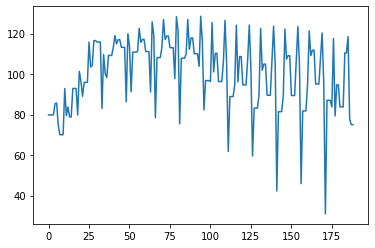

In [15]:
# Get column-wise sums
sums = results['CKA'].sum(axis=0).numpy()
plt.plot(np.arange(len(sums)),sums)

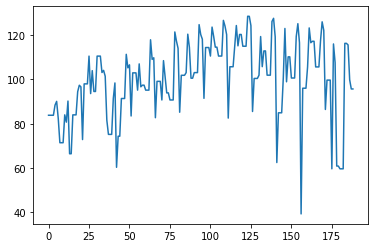

In [16]:
# Get row-wise sums
sums = results['CKA'].sum(axis=1).numpy()
plt.plot(np.arange(len(sums)),sums)